In [1]:
if 'libraries_imported' not in globals():
    libraries_imported = False

if libraries_imported == False:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os
    from datetime import datetime, timedelta
    from datetime import datetime
    from scipy.interpolate import make_interp_spline
    import plotly.graph_objects as go
    from scipy.signal import butter, filtfilt
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import StandardScaler
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
    from keras_tuner import RandomSearch, HyperModel
    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import StandardScaler
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense
    from tensorflow.keras.callbacks import EarlyStopping
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
    from keras_tuner import RandomSearch, HyperModel
    from tensorflow.keras.layers import Input
    import sys
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestRegressor
    import numpy as np
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import RobustScaler
    import tensorflow as tf
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    from sklearn.preprocessing import RobustScaler
    import joblib
    from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
    from sklearn.utils.class_weight import compute_class_weight
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import joblib
    import tensorflow as tf
    from sklearn.preprocessing import RobustScaler
    from sklearn.model_selection import train_test_split
    from sklearn.utils.class_weight import compute_class_weight
    from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
    import numpy as np
    import pandas as pd
    import joblib
    import tensorflow as tf
    from sklearn.model_selection import train_test_split
    from imblearn.over_sampling import SMOTE


    # # Display the first few rows
    # import ace_tools as tools  # Importing display tool


/home/harvey/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2025-10-06 17:12:27.795925: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-06 17:12:27.814179: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759767147.836897  877357 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory 

/tmp/ipykernel_877357/811799977.py:78: FutureWarning: DataFrame.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  out[num_cols] = out[num_cols].interpolate(method="ffill")
/tmp/ipykernel_877357/811799977.py:78: FutureWarning: DataFrame.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  out[num_cols] = out[num_cols].interpolate(method="ffill")


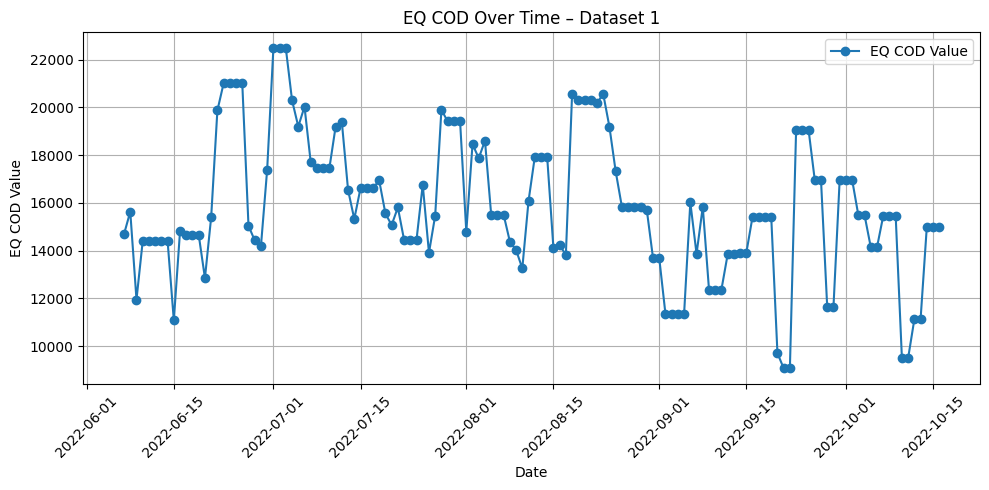

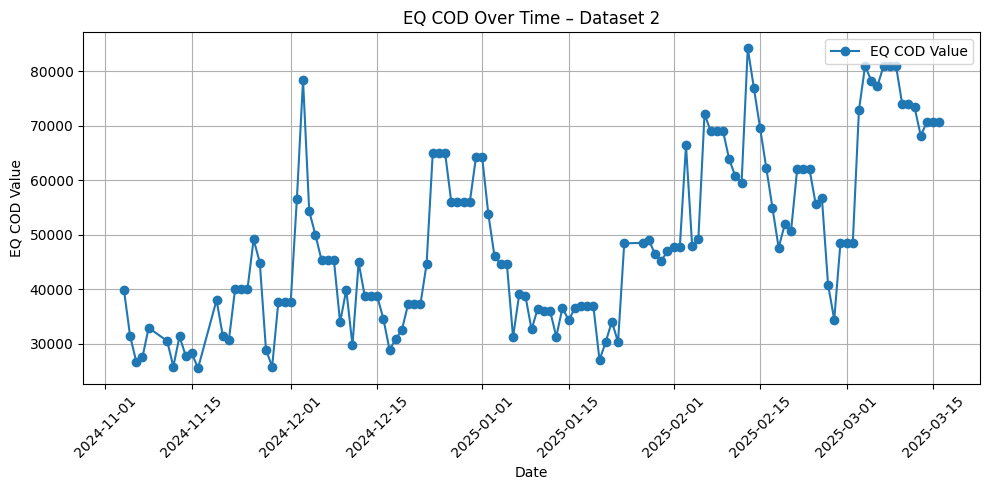

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# Config
# ----------------------------
DATASET1_PATH = "datasets/s_dataset1.csv"
DATASET2_PATH = "datasets/c_dataset2.csv"

DROP_COLS = ["h2s_ppm", "t1_cod", "t1_olr", "fostac"]
DROP_FROM_DATASET1 = ["index", "datetime", "f/m_ratio", "fos", "tac"]


# ----------------------------
# Helpers
# ----------------------------
def safe_drop(df: pd.DataFrame, cols) -> pd.DataFrame:
    """Drop columns if they exist."""
    existing = [c for c in cols if c in df.columns]
    return df.drop(columns=existing) if existing else df


def preprocess_common(df: pd.DataFrame) -> pd.DataFrame:
    """Reset index, ensure datetime type on 'date', sort by date."""
    out = df.copy()
    out.reset_index(drop=True, inplace=True)
    out["date"] = pd.to_datetime(out["date"], dayfirst=True, errors="coerce")
    out.sort_values("date", inplace=True)
    return out


def align_to_dataset1_columns(df1: pd.DataFrame, df2: pd.DataFrame):
    """
    Align df2's columns (order/presence) to df1's columns, using df1 as the schema.
    Columns missing in df2 will be added with NA; extras in df2 are dropped.
    """
    col_order = ["date"] + [c for c in df1.columns if c != "date"]
    df1 = df1[col_order]  # already guaranteed
    df2 = df2.reindex(columns=col_order)
    return df1, df2


def load_dataset1(path: str) -> pd.DataFrame:
    """
    Dataset 1:
      - parse 'datetime' (format: '%d.%m.%y') to 'date'
      - drop duplicates and unused columns
    """
    df = pd.read_csv(path)
    if "datetime" in df.columns:
        df["date"] = pd.to_datetime(df["datetime"], format="%d.%m.%y", errors="coerce")
    df = safe_drop(df, DROP_FROM_DATASET1)
    df = df.drop_duplicates()
    df["date"] = pd.to_datetime(df["date"], dayfirst=True, errors="coerce")
    return df


def load_dataset2(path: str) -> pd.DataFrame:
    """
    Dataset 2:
      - parse 'date'
      - daily mean aggregation
      - multiply 'methane_percentage' by 100 if present
    """
    df = pd.read_csv(path)
    df["date"] = pd.to_datetime(df.get("date"), errors="coerce")
    df = df.groupby("date", as_index=False).mean(numeric_only=True)
    df = df.drop_duplicates()
    if "methane_percentage" in df.columns:
        df["methane_percentage"] = df["methane_percentage"] * 100
    return df


def interpolate_forward_fill(df: pd.DataFrame, drop_remaining_na: bool = True) -> pd.DataFrame:
    """Forward-fill numeric columns; optionally drop remaining NA rows."""
    num_cols = df.select_dtypes(include="number").columns.tolist()
    out = df.copy()
    out[num_cols] = out[num_cols].interpolate(method="ffill")
    if drop_remaining_na:
        out = out.dropna()
    return out


def plot_eq_cod(df: pd.DataFrame, title: str):
    """Simple time-series plot for 'eq_cod'."""
    if "eq_cod" not in df.columns:
        raise KeyError("'eq_cod' column not found for plotting.")
    plt.figure(figsize=(10, 5))
    plt.plot(df["date"], df["eq_cod"], marker="o", label="EQ COD Value")
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("EQ COD Value")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# ----------------------------
# Pipeline
# ----------------------------
dataset1_df = load_dataset1(DATASET1_PATH)
dataset2_df = load_dataset2(DATASET2_PATH)

# Drop columns not needed (safely)
dataset1_df = safe_drop(dataset1_df, DROP_COLS)
dataset2_df = safe_drop(dataset2_df, DROP_COLS)

# Prep & align
dataset1_df = preprocess_common(dataset1_df)
dataset2_df = preprocess_common(dataset2_df)
dataset1_df, dataset2_df = align_to_dataset1_columns(dataset1_df, dataset2_df)

# Interpolate (forward-fill), drop remaining NA rows
dataset1_df_interpolated = interpolate_forward_fill(dataset1_df, drop_remaining_na=False)
dataset2_df_interpolated = interpolate_forward_fill(dataset2_df, drop_remaining_na=True)

# Plots
plot_eq_cod(dataset1_df, "EQ COD Over Time – Dataset 1")
plot_eq_cod(dataset2_df, "EQ COD Over Time – Dataset 2")


Inspect Feature importances


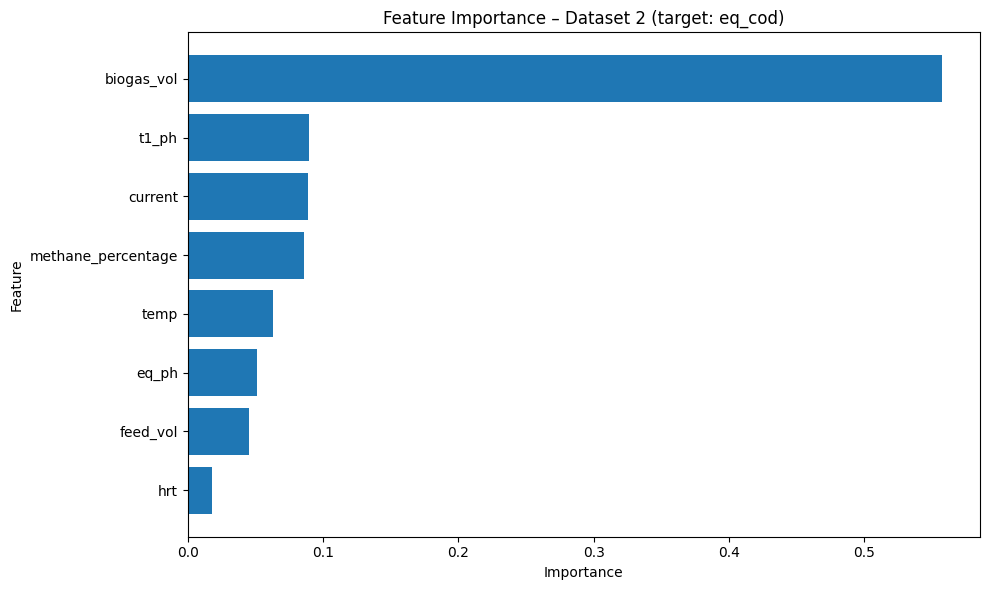


Top features – Dataset 2:
              feature  importance
7          biogas_vol    0.557721
6               t1_ph    0.089745
5             current    0.089215
4  methane_percentage    0.086003
3                temp    0.062963
2               eq_ph    0.050903
1            feed_vol    0.045283
0                 hrt    0.018167


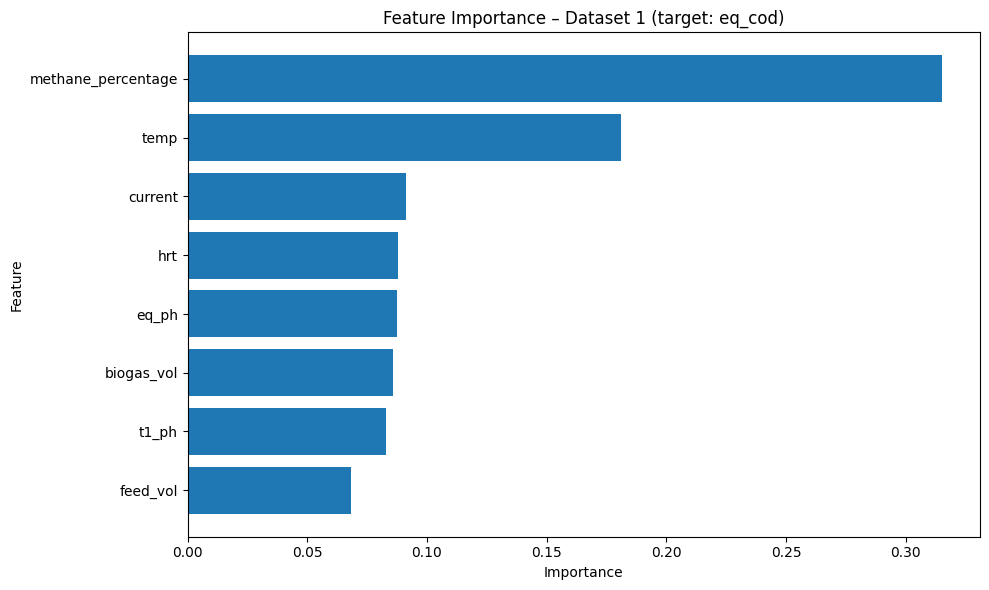


Top features – Dataset 1:
              feature  importance
7  methane_percentage    0.315308
6                temp    0.180883
5             current    0.091273
4                 hrt    0.087842
3               eq_ph    0.087489
2          biogas_vol    0.085961
1               t1_ph    0.082795
0            feed_vol    0.068450

Dataset 2 summary:
                                date       eq_ph        eq_cod    feed_vol  \
count                            127  127.000000    127.000000  127.000000   
mean   2025-01-10 12:28:20.787401472    4.185748  48554.527559   74.176063   
min              2024-11-04 00:00:00    3.600000  25500.000000    0.000000   
25%              2024-12-09 12:00:00    3.897500  36462.500000   57.500000   
50%              2025-01-10 00:00:00    4.033333  45300.000000   79.980000   
75%              2025-02-12 12:00:00    4.300000  62000.000000  100.000000   
max              2025-03-16 00:00:00    7.300000  84200.000000  180.000000   
std                    

In [9]:
# --- Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


# --- Feature importance utility
def feature_importance_analysis(
    df: pd.DataFrame,
    target: str,
    ignore_cols=None,
    *,
    n_estimators: int = 300,
    test_size: float = 0.2,
    random_state: int = 42,
    title: str | None = None
) -> pd.DataFrame:
    """
    Train a RandomForestRegressor and return/plot sorted feature importances.

    - Drops non-numeric columns (except the target if numeric).
    - Drops rows with NA in features or target.
    - Returns a DataFrame with features and importances (ascending).
    """
    if ignore_cols is None:
        ignore_cols = []

    # Ensure target exists
    if target not in df.columns:
        raise KeyError(f"Target column '{target}' not found in DataFrame.")

    # Build modeling DataFrame
    cols_to_drop = set(ignore_cols + [target])
    X_full = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors="ignore")

    # Keep only numeric features
    X_full = X_full.select_dtypes(include="number")
    if X_full.empty:
        raise ValueError("No numeric features available after dropping ignored columns.")

    # Combine features + target, drop NA rows to align
    model_df = pd.concat([X_full, df[target]], axis=1).dropna()
    if model_df.empty:
        raise ValueError("No rows left after dropping NaNs for features/target.")

    X = model_df.drop(columns=[target])
    y = model_df[target]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Fit model
    model = RandomForestRegressor(
        n_estimators=n_estimators, random_state=random_state
    )
    model.fit(X_train, y_train)

    # Importances sorted (ascending)
    importances = model.feature_importances_
    features = np.array(X.columns)
    order = np.argsort(importances)

    importance_df = pd.DataFrame(
        {"feature": features[order], "importance": importances[order]}
    ).reset_index(drop=True)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["feature"], importance_df["importance"])
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title(title or f"Feature Importance – {target}")
    plt.tight_layout()
    plt.show()

    return importance_df


# =========================
# Example usage
# (Assumes you already created dataset1_df_interpolated and dataset2_df_interpolated
#  from the earlier refactor.)
# =========================

# Dataset 2 (previously cook_df)
importance_dataset2 = feature_importance_analysis(
    df=dataset2_df_interpolated,
    target="eq_cod",
    ignore_cols=["date"],
    title="Feature Importance – Dataset 2 (target: eq_cod)"
)
print("\nTop features – Dataset 2:")
print(importance_dataset2.sort_values("importance", ascending=False).head(10))

# Dataset 1 (previously saniWASE_df)
importance_dataset1 = feature_importance_analysis(
    df=dataset1_df_interpolated,
    target="eq_cod",
    ignore_cols=["date"],
    title="Feature Importance – Dataset 1 (target: eq_cod)"
)
print("\nTop features – Dataset 1:")
print(importance_dataset1.sort_values("importance", ascending=False).head(10))

# Optional: quick sanity summaries
print("\nDataset 2 summary:")
print(dataset2_df_interpolated.describe(include="all"))
print("\nDataset 1 summary:")
print(dataset1_df_interpolated.describe(include="all"))


Basic feature engineering -- Add mvoing averages
